## I. Extract recorded data and describe status

In [85]:
import os
import json
import numpy as np

experiment_dir = "../experiments/random_architectures_with_loss"
dir_depth      = 4

# Get list of json files
filenames = [f for f in os.listdir(experiment_dir) if os.path.isfile(os.path.join(experiment_dir, f))]
data = []

# Get content
for filename in filenames:
    full_path = os.path.join(experiment_dir, filename)
    config = json.load( open( full_path) )
    # Fix for old files where there was a typo
    if 'FPT' in config:
        FPT_key = 'FPT'
    elif 'FTP' in config:
        FPT_key = 'FTP'
    else:
        assert(False)
    if not 'Results' in config:
        data_element = { 'filename': filename, **config[FPT_key], 'learning_curve_train': [], 'learning_curve_acc': [] }
    elif not 'learning_curve_acc' in config['Results']:
        data_element = { 'filename': filename, **config[FPT_key], **config['Results'], 'learning_curve_acc': [] }
    else:
        data_element = { 'filename': filename, **config[FPT_key], **config['Results'] }
    data.append( data_element )
    
for e in data:
    # Clean up
    #del e['quantiles']
    del e['cumulative']
    del e['density']
    # Format
    print(e['filename'], ':')
    quantile_count = len(e['quantiles'])
    print( f'  |- {quantile_count} quantiles available')
    samples_count  = len(e['learning_curve_train'])
    print( f'  |- {samples_count} training samples available' )
    rounded_losses = np.round( e['learning_curve_train'], decimals=4 )
    print( f'  |- Losses ', rounded_losses )
    rounded_acc = np.round( e['learning_curve_acc'], decimals=4 )
    print( f'  |- Accuracies ', rounded_acc )

random_Mon_Feb_7_22-50-42_2022.json :
  |- 11 quantiles available
  |- 5 training samples available
  |- Losses  [0.2775 0.2764 0.279  0.2797 0.2773]
  |- Accuracies  [0.9221 0.922 ]
random_Fri_Oct_15_09-15-52_2021.json :
  |- 11 quantiles available
  |- 7 training samples available
  |- Losses  [0.1762 0.1784 0.1746 0.1729 0.1779 0.1746 0.1743]
  |- Accuracies  [0.9493 0.9493]
random_Fri_Oct_15_08-44-05_2021.json :
  |- 11 quantiles available
  |- 7 training samples available
  |- Losses  [0.1159 0.1178 0.1148 0.1163 0.1154 0.1161 0.1165]
  |- Accuracies  [0.9614 0.9632]
random_Mon_Feb_7_22-57-04_2022.json :
  |- 11 quantiles available
  |- 5 training samples available
  |- Losses  [0.2842 0.2862 0.2848 0.282  0.2848]
  |- Accuracies  [0.9203 0.9206]
random_Mon_Feb_7_22-47-24_2022.json :
  |- 11 quantiles available
  |- 5 training samples available
  |- Losses  [0.1826 0.1865 0.182  0.1831 0.1829]
  |- Accuracies  [0.9487 0.9466]
random_Mon_Feb_7_22-44-58_2022.json :
  |- 11 quantiles

In [86]:
scatter_data = {}

for i in range(11):
    scatter_data[i] = []

for e in data:
    train_sample = e['learning_curve_train']
    for s in train_sample:
        for i in range(11):
            if s < 0.5: # Remove frozen outliers
                scatter_data[i].append( (e['quantiles'][i], s, e))

# Data points for each quantile
for i in range(11):
    print( i, ':', len(scatter_data[i]) )

0 : 429
1 : 429
2 : 429
3 : 429
4 : 429
5 : 429
6 : 429
7 : 429
8 : 429
9 : 429
10 : 429


## II. Scatter plots Loss vs quantile

Correlation measures: 
Spearman: SpearmanrResult(correlation=-0.05503623142465429, pvalue=0.25534431880439923)
Pearson : (-0.12960343221275034, 0.007190288313183494)
R2      : -0.12960343221275028


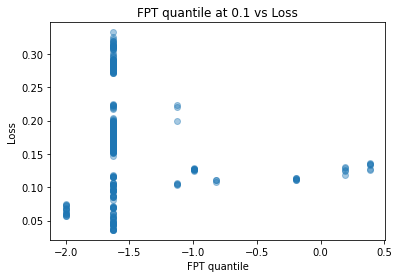

Correlation measures: 
Spearman: SpearmanrResult(correlation=-0.04376530848141237, pvalue=0.3658525737714211)
Pearson : (-0.15233637826031995, 0.0015533799784460275)
R2      : -0.15233637826032


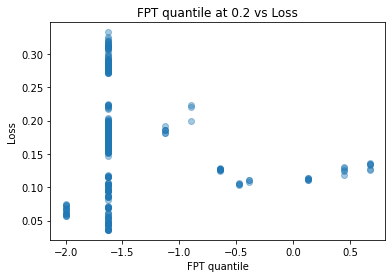

Correlation measures: 
Spearman: SpearmanrResult(correlation=-0.2625292112927547, pvalue=3.4128642993263556e-08)
Pearson : (-0.24115166448024994, 4.3032240963845935e-07)
R2      : -0.24115166448025008


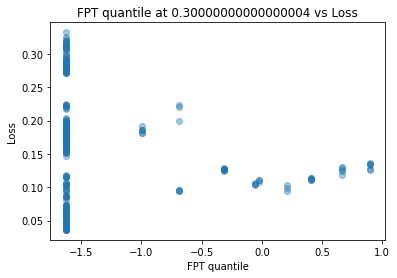

Correlation measures: 
Spearman: SpearmanrResult(correlation=-0.24389437096890623, pvalue=3.148864282189037e-07)
Pearson : (-0.26422831336282854, 2.762537790978615e-08)
R2      : -0.26422831336282854


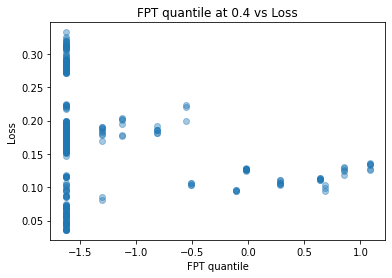

Correlation measures: 
Spearman: SpearmanrResult(correlation=-0.22409998921248006, pvalue=2.761018275190418e-06)
Pearson : (-0.2887412532273046, 1.1059786756976674e-09)
R2      : -0.28874125322730465


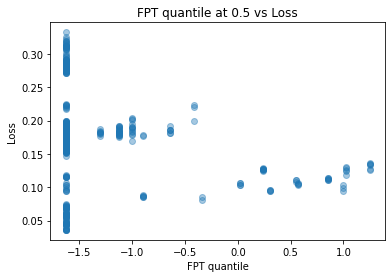

Correlation measures: 
Spearman: SpearmanrResult(correlation=-0.2829639305227858, pvalue=2.4298910182063546e-09)
Pearson : (-0.35094182084321296, 7.04341758466854e-14)
R2      : -0.35094182084321285


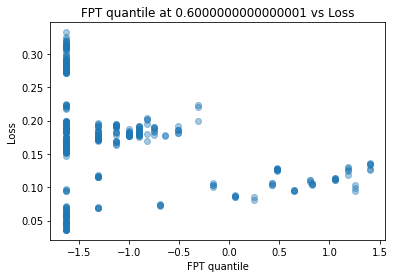

Correlation measures: 
Spearman: SpearmanrResult(correlation=-0.39191216797413453, pvalue=3.3558784957531544e-17)
Pearson : (-0.455321661096984, 2.4100301183090785e-23)
R2      : -0.4553216610969844


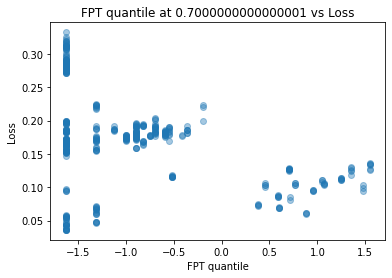

Correlation measures: 
Spearman: SpearmanrResult(correlation=-0.5849803778101913, pvalue=9.553422085697755e-41)
Pearson : (-0.6419125706562211, 3.399865863664837e-51)
R2      : -0.641912570656221


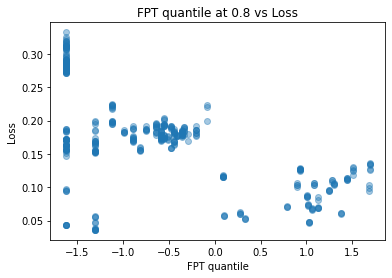

Correlation measures: 
Spearman: SpearmanrResult(correlation=-0.8028443970083159, pvalue=5.890024990714491e-98)
Pearson : (-0.8709158941952619, 7.963351858547651e-134)
R2      : -0.8709158941952626


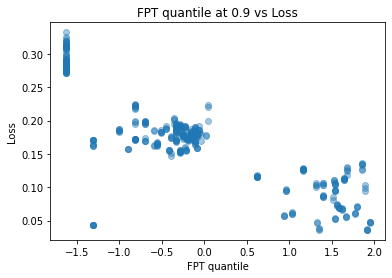

In [87]:
import matplotlib.pyplot as plt
import scipy
from scipy import stats

# Means 

# Quantiles
for i in range(1,10):
    # Bivariate analysis of quantiles and losses
    x = [np.log10(x+0.01) for (x,y,e) in scatter_data[i]]
    y = [y for (x,y,e) in scatter_data[i]]
    spearman = scipy.stats.spearmanr(x, y)
    pearson  = scipy.stats.pearsonr(x, y)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    print("Correlation measures: ")
    print("Spearman:", spearman )
    print("Pearson :", pearson  )
    print("R2      :", r_value)
    # Plot
    plt.scatter( x, y , alpha=0.4)
    plt.title(f'''FPT quantile at {i*0.1} vs Loss''')
    plt.xlabel("FPT quantile")
    plt.ylabel("Loss")
    plt.savefig(f'''FTP_quantile{i*10}.png''')
    plt.show()


In [88]:
!pip install scipy


## III. Interactive plot using Plotly

In [89]:
!pip install plotly pandas

In [90]:
import plotly.express as px
import pandas

# Quantiles
for i in range(9,10):
    # Bivariate analysis of quantiles and losses
    x = [np.log10(x+0.01) for (x,y,e) in scatter_data[i]]
    y = [y for (x,y,e) in scatter_data[i]]
    # Additionnal data
    more = [e for (x,y,e) in scatter_data[i]]
    filenames  = [ e['filename'] for e in more]
    widths     = [ e['width_ratios'] for e in more]
    accuracies = [ e['learning_curve_acc'] for e in more]
    # Correlations
    spearman = scipy.stats.spearmanr(x, y)
    pearson  = scipy.stats.pearsonr(x, y)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    print("Correlation measures: ")
    print("Spearman:", spearman )
    print("Pearson :", pearson  )
    print("R2      :", r_value)
    data_dict = {
        'log_quantile' : x,
        'loss'         : y,
        'filename'     : filenames,
        'width_profile': widths,
        'accuracy'     : accuracies
    }
    #print(more)
    df = pandas.DataFrame.from_dict( data_dict )
    fig = px.scatter( data_dict, x='log_quantile', y='loss', 
                      color='loss',
                      hover_data=['filename', 'width_profile', 'accuracy']
                    )
    fig.show()

Correlation measures: 
Spearman: SpearmanrResult(correlation=-0.8028443970083159, pvalue=5.890024990714491e-98)
Pearson : (-0.8709158941952619, 7.963351858547651e-134)
R2      : -0.8709158941952626


## III. Regression on all quantiles

In [93]:
!pip install statsmodels

In [94]:
Xtrain = []
Ytrain = []
for i in range(1,10):
    # Bivariate analysis of quantiles and losses
    x = [np.log10(x+0.01) for (x,y,e) in scatter_data[i]]
    x = np.array(x)
    Xtrain.append(x)
    Ytrain = [y for (x,y,e) in scatter_data[i]]
Xtrain = np.stack( Xtrain ).T
Ytrain = np.array( Ytrain )

print(Xtrain.shape)
print(Ytrain.shape)

import statsmodels.api as sm
X1train = sm.add_constant(Xtrain)
print(X1train.shape)
reg = sm.OLS(Ytrain,X1train)
resReg = reg.fit()
print(resReg.summary())

(429, 9)
(429,)
(429, 10)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     228.8
Date:                Sat, 16 Apr 2022   Prob (F-statistic):          1.23e-155
Time:                        05:21:22   Log-Likelihood:                 895.25
No. Observations:                 429   AIC:                            -1770.
Df Residuals:                     419   BIC:                            -1730.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2173     

## IV. Attempt at plot for all quantiles

Correlation measures: (correlation, p_value)
Spearman: -0.07991481027968876 0.16318233600737994
Pearson : (-0.05623345690940012, 0.32687199992114463)
R2      : -0.05623345690940013
Spearman: -0.0618563170486543 0.2807444963763668
Pearson : (-0.08549260038414422, 0.13566712523618)
R2      : -0.08549260038414419
Spearman: -0.26997348068784854 1.6466372194416246e-06
Pearson : (-0.24962828765747394, 9.916062052780186e-06)
R2      : -0.24962828765747389
Spearman: -0.2478092054763237 1.1558839515978013e-05
Pearson : (-0.27175142946685593, 1.3974804440554057e-06)
R2      : -0.27175142946685593
Spearman: -0.22531208454511165 6.994571627027091e-05
Pearson : (-0.2950580377661445, 1.457885793765101e-07)
R2      : -0.29505803776614437
Spearman: -0.2810015528993487 5.839998999096055e-07
Pearson : (-0.35741307187124144, 1.19026991773754e-10)
R2      : -0.35741307187124155
Spearman: -0.3831266771435193 3.887934508058172e-12
Pearson : (-0.4562621221223903, 3.86651766103737e-17)
R2      : -0.4562621221

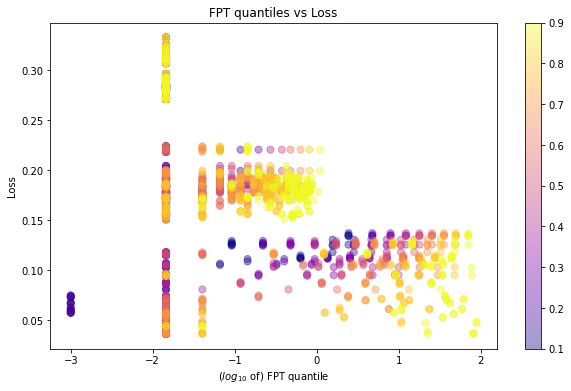

In [7]:
import matplotlib.pyplot as plt
import scipy
from scipy import stats

# Means 

# Quantiles
fig = plt.figure( figsize = (10,6) )
ax  = fig.add_subplot( 111 )
final_x = []
final_y = []
final_c = []
print("Correlation measures: (correlation, p_value)")
for i in range(1,10):
    # Bivariate analysis of quantiles and losses
    x = [np.log10(x+0.001) for (x,y) in scatter_data[i]]
    #x = [x for (x,y) in scatter_data[i]]
    y = [y for (x,y) in scatter_data[i]]
    spearman = scipy.stats.spearmanr(x, y)
    pearson  = scipy.stats.pearsonr(x, y)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    print("Spearman:", spearman[0], spearman[1] )
    print("Pearson :", pearson  )
    print("R2      :", r_value)
    # Plot
    color = [i*0.1]*len(x)
    final_x = final_x + x
    final_y = final_y + y
    final_c = final_c + color
#
scale = 50
plt.scatter( final_x, final_y, alpha=0.4, c=final_c, s=scale, cmap='plasma')
plt.colorbar()
plt.title(f'''FPT quantiles vs Loss''')
plt.xlabel("($log_{10}$ of) FPT quantile")
plt.ylabel("Loss")
plt.savefig(f'''FTP_quantile{i*10}.png''')
plt.show()
